Code taken from gym-anytrading and https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html with optmisation on top by me.

In [129]:
#use gym and gym-anytrading to train an agent to trade forex
#use dnq algorithm to train the agent to trade
#use the trained agent to trade

"""A long position implies that the trader expects the price of the asset to increase. 
The position implying that buying the asset with the anticipation that the asset's price will increase.
A short position  means the trader expects the price to decrease.When the agent takes a short position, it's selling the asset
The starting position of the environment is always Short"""

import gym
import gym_anytrading
from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import math
from collections import deque, namedtuple
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from itertools import count


warnings.filterwarnings('ignore')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

is_ipython = 'inline' in matplotlib.get_backend()

cpu


custom_env information:
> shape: (10, 2)
> df.shape: (6225, 5)
> prices.shape: (300,)
> signal_features.shape: (300, 2)
> max_possible_profit: 1.1229001800089833


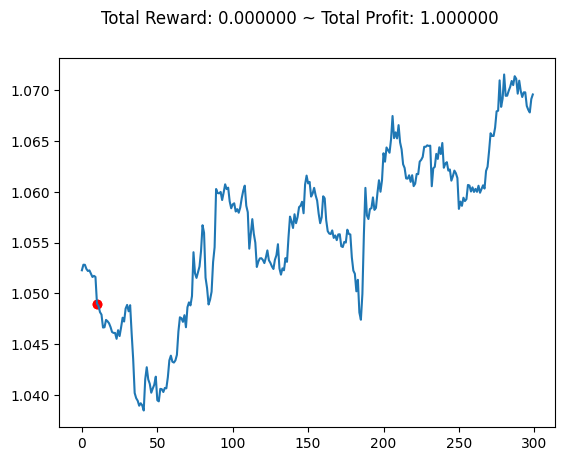

In [130]:
#set the enviroment as a custom enviroment with the forex data
custom_env = gym.make('forex-v0',
               df = FOREX_EURUSD_1H_ASK,
               window_size = 10,
               frame_bound = (10, 300),
               unit_side = 'right') # represents the unit of the account currency (right = USD)

print("custom_env information:")
print("> shape:", custom_env.shape)
print("> df.shape:", custom_env.df.shape)
print("> prices.shape:", custom_env.prices.shape)
print("> signal_features.shape:", custom_env.signal_features.shape)
print("> max_possible_profit:", custom_env.max_possible_profit())

#plot the enviroment
custom_env.reset()
custom_env.render()


In [131]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

# Replay memory to store transitions for training the DQN agent
# During the learning process, the agent's experiences (state, action, reward, next state) are stored in a replay buffer. 
# The agent then samples a batch of experiences from this buffer to learn from, rather than learning from consecutive experiences.
# This approach breaks the correlation between experiences and therefore reduces the variance of the updates. 
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, *args): #Save a transition
        self.memory.append(args)

    def sample(self, batch_size): #Sample a batch of transitions
        return random.sample(self.memory, batch_size)

    def __len__(self): #Return the length of the memory
        return len(self.memory)

class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128) #input layer
        self.layer2 = nn.Linear(128, 128) #hidden layer
        self.layer3 = nn.Linear(128, n_actions) #output layer

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):

        #use elu to avoid dead neurons
        x = F.elu(self.layer1(x))
        x = F.elu(self.layer2(x))

        #use leaky relu to avoid dead neurons
        #x = F.leaky_relu(self.layer1(x))
        #x = F.leaky_relu(self.layer2(x))

        #x = F.relu(self.layer1(x))
        #x = F.relu(self.layer2(x))

        return self.layer3(x)        

In [132]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 32
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# The number of actions are 2: buy or sell
n_actions = 2

# Get the number of state observations
state  = custom_env.reset()
state = torch.tensor(state, dtype=torch.float32, device=device).flatten().unsqueeze(0)
n_observations = len(state)


policy_net = DQN(20, n_actions).to(device)
target_net = DQN(20, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(100000)
memory1  = PrioritizedReplayBuffer(capacity=100000)

steps_done = 0


def select_action(state, eps_threshold):
    sample = random.random()
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[custom_env.action_space.sample()]], device=device, dtype=torch.long)



episode_durations = []



In [ ]:
def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if show_result:
        if is_ipython:
            display(plt.gcf())
    else:
        display(plt.gcf())
        clear_output(wait=True)

In [133]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

def calculate_epsilon(steps_done): #calculate epsilon for epsilon-greedy policy 
    return EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)


In [134]:
num_episodes = 600 if torch.cuda.is_available() else 30
batch_size = 128 if torch.cuda.is_available() else 32

for _ in range(num_episodes): 

    # Initialize the environment and get it's state
    eps_threshold = calculate_epsilon(steps_done)

    state = custom_env.reset()
    state = state.flatten()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    # For each step in the episode (until it's done)
    for t in count():
        action = select_action(state, eps_threshold)
        observation, reward, terminated, truncated = custom_env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        next_state = ( 
            None
            if terminated
            else torch.tensor(
                observation, dtype=torch.float32, device=device
            ).unsqueeze(0)
        )
        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for target_param, policy_param in zip(target_net.parameters(), policy_net.parameters()):
            target_param.data.copy_(TAU * policy_param.data + (1.0 - TAU) * target_param.data)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
    

<Figure size 640x480 with 0 Axes>

In [135]:
#plot the results
plot_durations()
plt.show()

<Figure size 640x480 with 0 Axes>

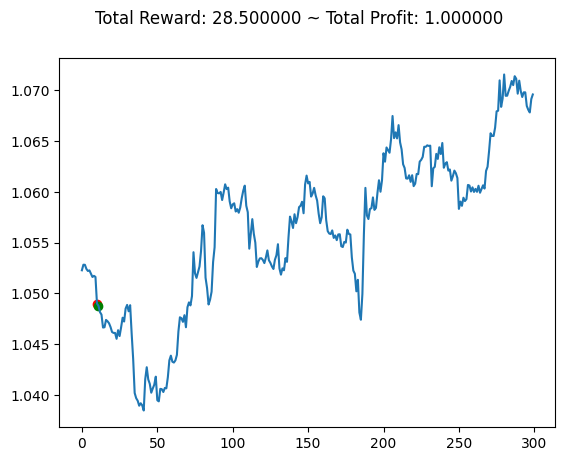

In [136]:
#use gym-tradeanything environment to plot the performance of the agent
#the red dot is initial state of the portfolio
#the green dot is the final state of the portfolio
custom_env.render()

In [ ]:
#the prioritized replay buffer should increase the performance of the DQN agent
"""simply replays transitions at the same frequency that they were originally experienced, regardless of their significance. 
In this paper we develop a framework for prioritizing experience, so as to replay important transitions more frequently, and therefore learn more efficiently. 
(https://arxiv.org/abs/1511.05952)"""
#

#todo implement prioritized replay buffer for DQN
class PrioritizedReplayBuffer:
    def __init__(self, capacity, prob_alpha=0.6):
        self.prob_alpha = prob_alpha
        self.capacity = capacity
        self.buffer = []
        self.pos = 0
        self.priorities = np.zeros(capacity, dtype=np.float32)

    # push a new transition into the buffer if the buffer is not full yet or replace the oldest transition with the new transition
    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append((state, action, reward, next_state, done))
        else:
            self.buffer[self.pos] = (state, action, reward, next_state, done)
        self.priorities[self.pos] = max(self.priorities)
        self.pos = (self.pos + 1) % self.capacity

    # sample a batch of transitions from the buffer
    def sample(self, batch_size, beta=0.4):
        probs = self.priorities ** self.prob_alpha
        probs /= probs.sum()
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]
        return samples, indices, probs[indices]

    # update the priorities of the sampled transitions
    def update_priorities(self, batch_indices, batch_priorities):
        for idx, prio in zip(batch_indices, batch_priorities):
            self.priorities[idx] = prio

    # return the number of transitions in the buffer
    def __len__(self):
        return len(self.buffer)